Imports first.

In [237]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
sns.set()

Next, we will load the challenge1 csv into a dataframe.
TODO: save the df to postgresql

In [238]:
df = pd.read_csv("challenge1.csv")
df

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50
...,...,...,...,...,...,...,...,...
9995,9,98,3,Fri,386,5000.0,12.0,460.00
9996,7,74,1,Thu,386,3250.0,8.0,325.00
9997,0,06,0,Tue,190,8856.0,5.6,133.33
9998,7,74,3,Fri,717,5000.0,13.6,820.00


I could just be missing it, but I don't know an easy way to put a numeric value on the categorical variable for the day of the week. In case there's a seasonality I'll appreciate the numeric data.

In [239]:
dow_numeric = []
for value in df['dow']:
    if value == 'Mon':
        dow_numeric.append(0)
    elif value == 'Tue':
        dow_numeric.append(1)
    elif value == 'Wed':
        dow_numeric.append(2)
    elif value == 'Thu':
        dow_numeric.append(4)
    elif value == 'Fri':
        dow_numeric.append(5)
    elif value == 'Sat':
        dow_numeric.append(6)
    elif value == 'Sun':
        dow_numeric.append(7)
    else:
        dow_numeric.append(pd.NA)
df.insert(4, 'dow_numeric', dow_numeric)
df

,loc1,loc2,para1,dow,dow_numeric,para2,para3,para4,price
0,0,01,1,Mon,0,662,3000.0,3.8,73.49
1,9,99,1,Thu,4,340,2760.0,9.2,300.00
2,0,04,0,Mon,0,16,2700.0,3.0,130.00
3,4,40,1,Mon,0,17,12320.0,6.4,365.00
4,5,50,1,Thu,4,610,2117.0,10.8,357.50
...,...,...,...,...,...,...,...,...,...
9995,9,98,3,Fri,5,386,5000.0,12.0,460.00
9996,7,74,1,Thu,4,386,3250.0,8.0,325.00
9997,0,06,0,Tue,1,190,8856.0,5.6,133.33
9998,7,74,3,Fri,5,717,5000.0,13.6,820.00


Next I just `describe()` the data.

In [240]:
df.describe()

,para1,dow_numeric,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,2.383100,447.384000,9547.989920,8.459522,433.733056
std,3.500831,1.828953,221.005861,8022.814037,4.613526,277.435947
min,0.000000,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,2.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,4.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,7.000000,2554.000000,34782.000000,27.200000,5700.000000


I noticed that the mean of the dow_numeric column looked 'low' to me, so I wanted to explore that a little deeper.

In [241]:
df.groupby(by=['dow']).size()

dow
Fri    1931
Mon    1918
Sat      10
Sun       3
Thu    1908
Tue    1997
Wed    2233
dtype: int64

Never mind that, Wednesday is a little overrepresented but the main reason for the low mean is there was barely any data on Saturday and Sunday specifically, which makes sense because those aren't usually business days. Doesn't look like I need to care about seasonality.

In [242]:
df.drop('dow_numeric', axis=1, inplace=True)
df.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


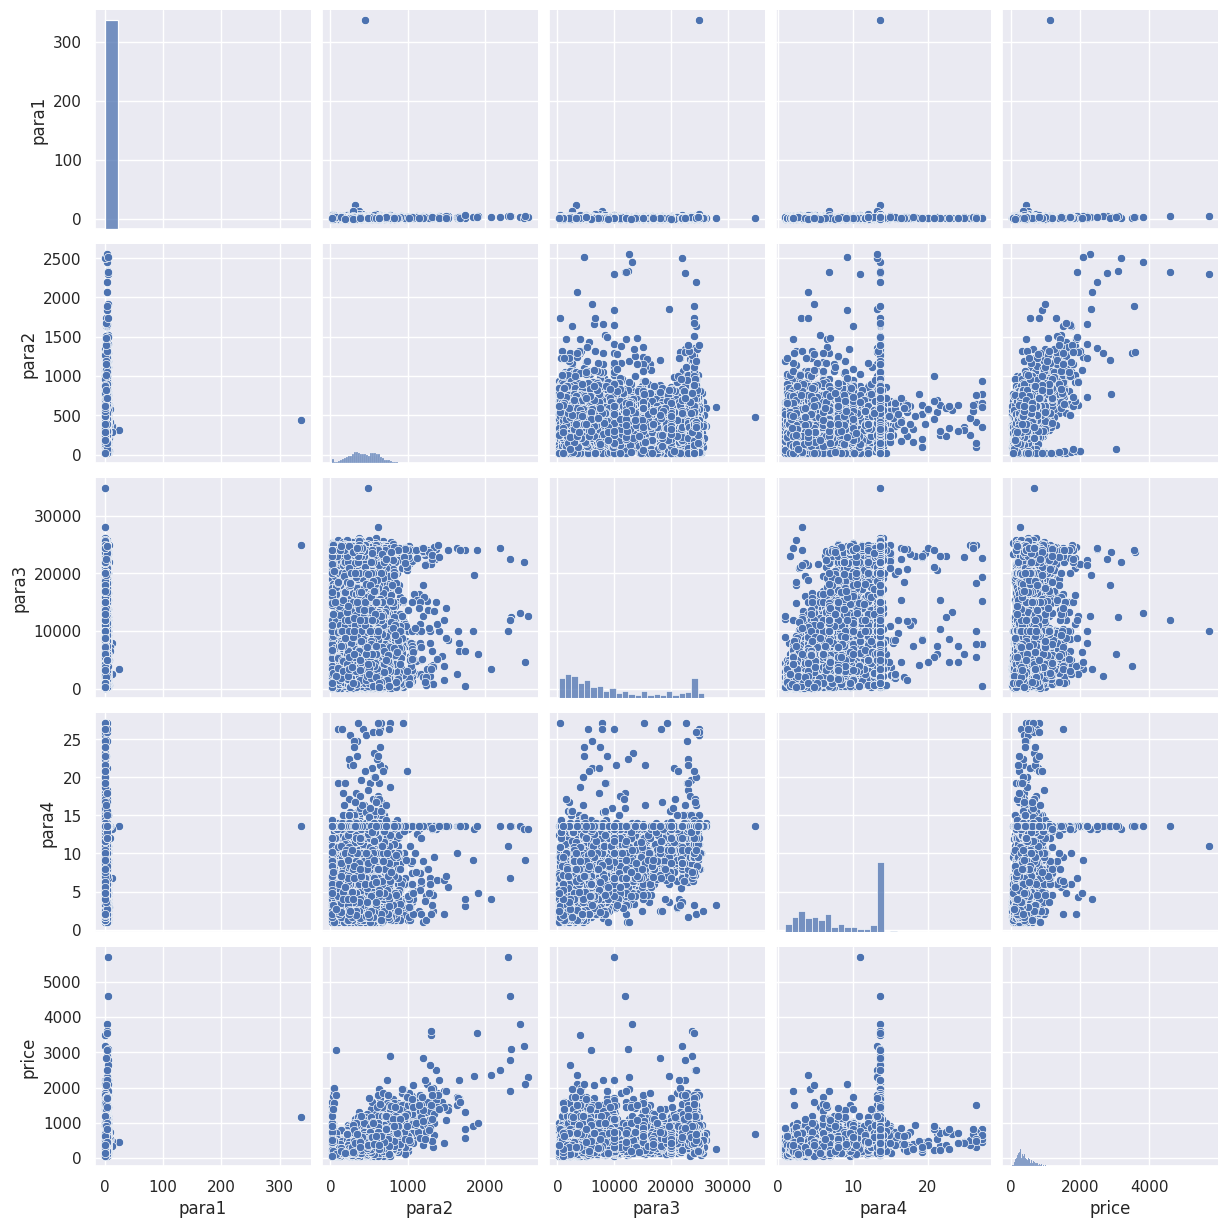

In [243]:
sns.pairplot(df)

Next, I want to take a look at the correlation between the four parameters. There seems to be a high correlation between para3 and para4 so I'll need to take a closer look.

In [244]:
df.corr()

/tmp/ipykernel_31895/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,para1,para2,para3,para4,price
para1,1.000000,0.072025,0.010420,0.001663,0.074754
para2,0.072025,1.000000,0.006978,0.020806,0.552681
para3,0.010420,0.006978,1.000000,0.691237,0.355088
para4,0.001663,0.020806,0.691237,1.000000,0.514990
price,0.074754,0.552681,0.355088,0.514990,1.000000


Instead, I'll go ahead and build a linear regression model from the four parameters to predict the price. Using train_test_split so I don't have to initialize the four sets individually and don't have to worry about calculating how many records I should use. Does everything I need in just one line!

# Basic Linear Regression

In [245]:
# split the data set into the features and regressand

df_regressors = df[['para1', 'para2', 'para3', 'para4']]
df_regressand = df['price']

# divide the data sets into train and test sets
df_regressors_train, df_regressors_test, df_regressand_train, df_regressand_test = train_test_split(df_regressors, df_regressand, test_size=0.2)

Next we will create the model using the LinearRegression class in sklearn and make a prediction.

In [246]:
reg = linear_model.LinearRegression()
reg.fit(df_regressors_train, df_regressand_train)

df_regressand_prediction = reg.predict(df_regressors_test)


Now I'll just display the coefficients, the MSE, the R<sup>2</sup> Error and the adjusted R<sup>2</sup>. We end up with middling explanatory power in my opinion, but I seem to remember that that is expected as you add independent variables.

In [247]:
r2_error = r2_score(df_regressand_test, df_regressand_prediction)

print(f"Coefficients: {reg.coef_}")
print(f"Mean Squared Error: {mean_squared_error(df_regressand_test, df_regressand_prediction):.2f}")
print(f"R Squared Error: {r2_error*100:.2f}%")
print(f"Adjusted R Squared Error: {(1-(1-r2_error)*((2000-1)/(2000-4-1)))*100:.2f}%")
scores = cross_val_score(reg, df_regressors_train, df_regressand_train, scoring='r2', cv=10)
print(f"Accuracy: {scores.mean()} {scores.std()}")

Coefficients: [2.57130640e+00 6.78901013e-01 9.28287911e-05 3.03250809e+01]
Mean Squared Error: 31911.46
R Squared Error: 55.82%
Adjusted R Squared Error: 55.73%
Accuracy: 0.5098933655958032 0.14635982806741432


Above, I found that `para3` and `para4` were highly correlated, and here I found that `para3` is ending up with a tiny coefficient. I'll check two other models, one which leaves out `para3` and one which leaves out `para4`.

# Excluding `para3`

In [248]:
# split the data set into the features and regressand

df_regressors_no_p3 = df[['para1', 'para2', 'para4']]
df_regressand = df['price']

# divide the data sets into train and test sets
df_regressors_train, df_regressors_test, df_regressand_train, df_regressand_test = train_test_split(df_regressors_no_p3, df_regressand, test_size=0.2)

In [249]:
reg_no_p3 = linear_model.LinearRegression()
reg_no_p3.fit(df_regressors_train, df_regressand_train)

df_regressand_prediction = reg_no_p3.predict(df_regressors_test)


In [250]:
r2_error = r2_score(df_regressand_test, df_regressand_prediction)

print(f"Coefficients: {reg_no_p3.coef_}")
print(f"Mean Squared Error: {mean_squared_error(df_regressand_test, df_regressand_prediction):.2f}")
print(f"R Squared Error: {r2_error*100:.2f}%")
print(f"Adjusted R Squared Error: {(1-(1-r2_error)*((2000-1)/(2000-4-1)))*100:.2f}%")
scores = cross_val_score(reg_no_p3, df_regressors_train, df_regressand_train, scoring='r2', cv=10)
print(f"Accuracy: {scores.mean()} {scores.std()}")

Coefficients: [ 2.45294637  0.66138796 30.35357562]
Mean Squared Error: 38568.94
R Squared Error: 56.87%
Adjusted R Squared Error: 56.78%
Accuracy: 0.5124043157254381 0.12769727675427928


# Excluding `para4`

In [251]:
# split the data set into the features and regressand

df_regressors_no_p4 = df[['para1', 'para2', 'para3']]
df_regressand = df['price']

# divide the data sets into train and test sets
df_regressors_train, df_regressors_test, df_regressand_train, df_regressand_test = train_test_split(df_regressors_no_p4, df_regressand, test_size=0.2)

In [252]:
reg_no_p4 = linear_model.LinearRegression()
reg_no_p4.fit(df_regressors_train, df_regressand_train)

df_regressand_prediction = reg_no_p4.predict(df_regressors_test)


In [253]:
r2_error = r2_score(df_regressand_test, df_regressand_prediction)

print(f"Coefficients: {reg_no_p4.coef_}")
print(f"Mean Squared Error: {mean_squared_error(df_regressand_test, df_regressand_prediction):.2f}")
print(f"R Squared Error: {r2_error*100:.2f}%")
print(f"Adjusted R Squared Error: {(1-(1-r2_error)*((2000-1)/(2000-4-1)))*100:.2f}%")
scores = cross_val_score(reg_no_p4, df_regressors_train, df_regressand_train, scoring='r2', cv=10)
print(f"Accuracy: {scores.mean()} {scores.std()}")

Coefficients: [2.16037892 0.70481233 0.0122164 ]
Mean Squared Error: 38851.68
R Squared Error: 39.22%
Adjusted R Squared Error: 39.09%
Accuracy: 0.42297311919424335 0.06084040523611922


Excluding `para3` seems to produce merely "ok" results. The 69% correlation coefficient for `para3` and `para4` is just shy of "highly correlated" but I've shown that excluding either isn't a good path forward. New approach: let's try Ridge regression with a few $\alpha$ values.

# Ridge Regression

In [254]:
# divide the data sets into train and test sets
df_regressors_train, df_regressors_test, df_regressand_train, df_regressand_test = train_test_split(df_regressors, df_regressand, test_size=0.2)

This step here will cross-validate a series of Ridge regressions based on a list of $\alpha$ values and select the best one based on that cross-validation.

In [255]:
regr_cv = linear_model.RidgeCV(alphas=[0.1, 1.0, 5.0, 10.0, 15.0, 25.0, 50.0])
reg_ridge = regr_cv.fit(df_regressors_train, df_regressand_train)

df_regressand_prediction = reg_ridge.predict(df_regressors_test)

In [256]:
r2_error = r2_score(df_regressand_test, df_regressand_prediction)

print(f"Coefficients: {reg.coef_}")
print(f"Mean Squared Error: {mean_squared_error(df_regressand_test, df_regressand_prediction):.2f}")
print(f"R Squared Error: {r2_error*100:.2f}%")
print(f"Adjusted R Squared Error: {(1-(1-r2_error)*((2000-1)/(2000-4-1)))*100:.2f}%")
scores = cross_val_score(reg_ridge, df_regressors_train, df_regressand_train, scoring='r2', cv=10)
print(f"Accuracy: {scores.mean()} {scores.std()}")

Coefficients: [2.57130640e+00 6.78901013e-01 9.28287911e-05 3.03250809e+01]
Mean Squared Error: 40304.95
R Squared Error: 57.24%
Adjusted R Squared Error: 57.15%
Accuracy: 0.5198644722517927 0.12659668990521078


Hey, check that out! Our MSE is still better than the 2 totally failed models and the $R^2$ and $\bar{R}^2$ are both looking pretty good too. It looks like we have a better $R^2$ than earlier, too! It's important to note that the accuracy of this model as calculated by `cross_val_score` is lower than the basic linear regression.

Last thing I'll do is go ahead and commit the challenge1 csv to the postgresql database. Writing out the `declarative_base` class is a little tedious but you get so many benefits from using sqlalchemy.

In [257]:
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, DECIMAL, String
import psycopg2

Base = declarative_base()

class challenge1(Base):
    __tablename__ = 'challenge_1'
    id = Column(Integer, primary_key=True)
    loc1 = Column(Integer)
    loc2 = Column(Integer)
    para1 = Column(DECIMAL)
    dow = Column(String(3))
    para2 = Column(DECIMAL)
    para3 = Column(DECIMAL)
    para4 = Column(DECIMAL)
    price = Column(DECIMAL)

with open('../.pgpass', 'r') as f:
    host, port, database, user, password = f.read().split(':')

engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}', echo=False)
Base.metadata.create_all(engine)
df.to_sql(name=challenge1.__tablename__, con=engine, index=True, if_exists='replace')

1000

NOTE: the `.pgpass` file is being `.gitignore`d, I do know not to just leave secrets in repos.

Lastly, just to show the csv is getting imported properly, we read it back. 

NOTE: I'm not sure what the `loc1` and `loc2` columns are supposed to mean, they look like a multi-index or something but I would have to ask how they're supposed to work. I noticed in the CSV that there are 2 lines which have non-numeric values.

In [258]:
df2 = pd.read_sql_table(challenge1.__tablename__, con=engine)
print(df)
print(df2)

     loc1 loc2  para1  dow  para2    para3  para4   price
0       0   01      1  Mon    662   3000.0    3.8   73.49
1       9   99      1  Thu    340   2760.0    9.2  300.00
2       0   04      0  Mon     16   2700.0    3.0  130.00
3       4   40      1  Mon     17  12320.0    6.4  365.00
4       5   50      1  Thu    610   2117.0   10.8  357.50
...   ...  ...    ...  ...    ...      ...    ...     ...
9995    9   98      3  Fri    386   5000.0   12.0  460.00
9996    7   74      1  Thu    386   3250.0    8.0  325.00
9997    0   06      0  Tue    190   8856.0    5.6  133.33
9998    7   74      3  Fri    717   5000.0   13.6  820.00
9999    7   75      1  Thu    622    336.0    4.8  375.00

[10000 rows x 8 columns]
      index loc1 loc2  para1  dow  para2    para3  para4   price
0         0    0   01      1  Mon    662   3000.0    3.8   73.49
1         1    9   99      1  Thu    340   2760.0    9.2  300.00
2         2    0   04      0  Mon     16   2700.0    3.0  130.00
3         3    4  

Based on the cross-validation done on the above models, I would recommend the basic linear regression. Even testing a half-dozen Ridge regressions, we weren't able to beat the simple model. Thank you once again for the opportunity to show you some of my skills, and I'll be looking forward to hearing about the next steps.